In [1]:
# Data preparation
import pandas as pd
import numpy as np
from recreate_icip2022_face_reconstruction.src.det.implementations.DET import DET

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

import numpy

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8

In [29]:
# Global variables
block_size = 128
feature_extractor = "ElasticFace"

# ----
import os
#save_path = f"./DET_curves/"
# filename_plot = f"{}_pemiu{block_size}_performance.svg"
#os.makedirs(save_path, exist_ok=True)

In [30]:
df_genuine = pd.read_csv(f"../dataframes/elasticface/lfw_view2_genuine_pemiu{block_size}.csv", sep=",")
df_genuine

,Unnamed: 0,a_img,a_embedding_pemiu,b_img,b_embedding_pemiu,genuine,a_embedding_reconstructed,cos_sim_a_pemiu_a_pemiu_reconstructed
0,0,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.564878
1,1,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.821995
2,2,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.728067
3,3,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.507185
4,4,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.665197
...,...,...,...,...,...,...,...,...
2995,5695,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.461306
2996,5696,../data/lfw_align/Wang_Yi/Wang_Yi_0001.png,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Wang_Yi/Wang_Yi_0002.png,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.698034
2997,5697,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.683992
2998,5698,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0001.png,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0003.png,../data/lfw_align_embeddings_elastic_pemiu128/...,True,../data/lfw_align_embeddings_elastic_pemiu128_...,0.728986


# Evaluation of biometric performance for PEMIU enhanced templates

Ingest dataframes containing path to LFW View 2 Target A and Target B for
- Original image
- PEMIU Shuffled embedding
- PEMIU Reconstructed embedding
- Block Size: See global variable above
- cos_sim between PEMIU Shuffled and Reconstructed embeddings

Add columns pointing to the unmodified embeddings. Reorder the columns for better readability.

In [31]:
df_genuine = pd.read_csv(f"../dataframes/elasticface/lfw_view2_genuine_pemiu{block_size}.csv", sep=",")
df_impostor = pd.read_csv(f"../dataframes/elasticface/lfw_view2_impostor_pemiu{block_size}.csv", sep=",")

# Add a column just containing the target name without extension
df_genuine['a_filename'] = df_genuine['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_genuine['b_filename'] = df_genuine['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['a_filename'] = df_impostor['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['b_filename'] = df_impostor['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Add columns with path pointing to unmodified templates
path_unmodified = "../data/lfw_align_embeddings_elastic/"
df_genuine['a_embedding_unmodified'] = df_genuine['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_genuine['b_embedding_unmodified'] = df_genuine['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['a_embedding_unmodified'] = df_impostor['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['b_embedding_unmodified'] = df_impostor['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")


In [32]:
df_genuine.columns

Index(['Unnamed: 0', 'a_img', 'a_embedding_pemiu', 'b_img',
       'b_embedding_pemiu', 'genuine', 'a_embedding_reconstructed',
       'cos_sim_a_pemiu_a_pemiu_reconstructed', 'a_filename', 'b_filename',
       'a_embedding_unmodified', 'b_embedding_unmodified'],
      dtype='object')

In [33]:
# Rename index column
df_genuine = df_genuine.rename(columns = {"Unnamed: 0": "index"})
df_impostor = df_impostor.rename(columns = {"Unnamed: 0": "index"})

# Reorder columns
df_genuine = df_genuine[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

# Reorder columns
df_impostor = df_impostor[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

In [34]:
df_genuine

,index,a_filename,a_img,a_embedding_unmodified,a_embedding_pemiu,a_embedding_reconstructed,b_filename,b_img,b_embedding_unmodified,b_embedding_pemiu,cos_sim_a_pemiu_a_pemiu_reconstructed
0,0,Abel_Pacheco_0001,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic/Abel_Pach...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Abel_Pacheco_0004,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic/Abel_Pach...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.564878
1,1,Akhmed_Zakayev_0001,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.821995
2,2,Akhmed_Zakayev_0002,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.728067
3,3,Amber_Tamblyn_0001,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic/Amber_Tam...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Amber_Tamblyn_0002,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic/Amber_Tam...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.507185
4,4,Anders_Fogh_Rasmussen_0001,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic/Anders_Fo...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Anders_Fogh_Rasmussen_0003,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic/Anders_Fo...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.665197
...,...,...,...,...,...,...,...,...,...,...,...
2995,5695,Vladimir_Voltchkov_0001,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Vladimir_Voltchkov_0002,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.461306
2996,5696,Wang_Yi_0001,../data/lfw_align/Wang_Yi/Wang_Yi_0001.png,../data/lfw_align_embeddings_elastic/Wang_Yi_0...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Wang_Yi_0002,../data/lfw_align/Wang_Yi/Wang_Yi_0002.png,../data/lfw_align_embeddings_elastic/Wang_Yi_0...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.698034
2997,5697,Zafarullah_Khan_Jamali_0001,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic/Zafarulla...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Zafarullah_Khan_Jamali_0002,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic/Zafarulla...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.683992
2998,5698,Zhu_Rongji_0001,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0001.png,../data/lfw_align_embeddings_elastic/Zhu_Rongj...,../data/lfw_align_embeddings_elastic_pemiu128/...,../data/lfw_align_embeddings_elastic_pemiu128_...,Zhu_Rongji_0003,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0003.png,../data/lfw_align_embeddings_elastic/Zhu_Rongj...,../data/lfw_align_embeddings_elastic_pemiu128/...,0.728986


## Calculate cos_sim

Calculate cosine similarity of
- target a / b embedding

In [35]:
# Cosine similarity according to Terhörst PEMIU implementation
def cos_sim(a, b):
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [36]:
# Load embeddings
genuine_a = df_genuine['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
genuine_b = df_genuine['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_a = df_impostor['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_b = df_impostor['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()

# Calculate cosine similarity using scipy spacial distance
df_genuine['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(genuine_a, genuine_b)]
df_impostor['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(impostor_a, impostor_b)]

## Det



In [37]:
df_genuine_128 = df_genuine
df_impostor_128 = df_impostor

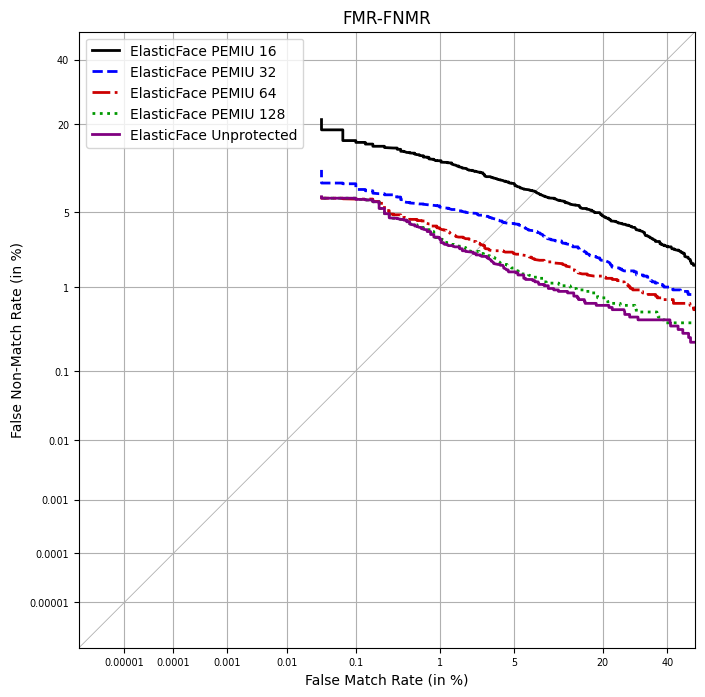

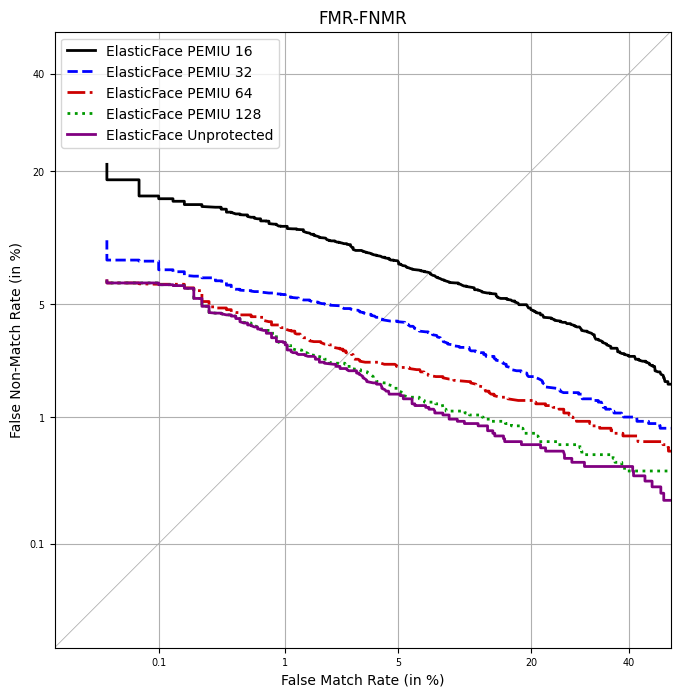

In [38]:
#     df_genuine['cos_sim_a_pemiu_a_pemiu_reconstructed_normalized'],
#    df_impostor['cos_sim_a_pemiu_a_pemiu_reconstructed_normalized'],
save_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_10_elastic/det_curves/"
os.makedirs(save_path, exist_ok=True)

tar0 = df_genuine_16['cos_sim_a_pemiu_a_pemiu_reconstructed']
non0 = df_impostor_16['cos_sim_a_pemiu_a_pemiu_reconstructed']
tar1 = df_genuine_32[f'cos_sim_a_pemiu_a_pemiu_reconstructed']
non1 = df_impostor_32[f'cos_sim_a_pemiu_a_pemiu_reconstructed']
tar2 = df_genuine_64[f'cos_sim_a_pemiu_a_pemiu_reconstructed']
non2 = df_impostor_64[f'cos_sim_a_pemiu_a_pemiu_reconstructed']
tar3 = df_genuine_128[f'cos_sim_a_pemiu_a_pemiu_reconstructed']
non3 = df_impostor_128[f'cos_sim_a_pemiu_a_pemiu_reconstructed']
tar4 = df_genuine_128[f'cos_sim_a_b']
non4 = df_impostor_128[f'cos_sim_a_b']

det = DET(biometric_evaluation_type='algorithm', plot_title='FMR-FNMR', plot_eer_line=True)
det.create_figure()
det.plot(tar=tar0, non=non0, label='ElasticFace PEMIU 16')
det.plot(tar=tar1, non=non1, label='ElasticFace PEMIU 32')
det.plot(tar=tar2, non=non2, label='ElasticFace PEMIU 64')
det.plot(tar=tar3, non=non3, label='ElasticFace PEMIU 128')
det.plot(tar=tar4, non=non4, label='ElasticFace Unprotected')
det.legend_on()
det.save(f'{save_path}example_algorithm', 'pdf')

det = DET(biometric_evaluation_type='algorithm', plot_title='FMR-FNMR', plot_eer_line=True)

det.x_limits = numpy.array([1e-4, .5])
det.y_limits = numpy.array([1e-4, .5])
det.x_ticks = numpy.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = numpy.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = numpy.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = numpy.array(['0.1', '1', '5', '20', '40'])

det.create_figure()
det.plot(tar=tar0, non=non0, label='ElasticFace PEMIU 16')
det.plot(tar=tar1, non=non1, label='ElasticFace PEMIU 32')
det.plot(tar=tar2, non=non2, label='ElasticFace PEMIU 64')
det.plot(tar=tar3, non=non3, label='ElasticFace PEMIU 128')
det.plot(tar=tar4, non=non4, label='ElasticFace Unprotected')
det.legend_on()
det.save(f'{save_path}example_algorithm_axes_final', 'pdf')